In [1]:
import os, re, time, json
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import numpy as np
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
from matplotlib import pyplot as plt
import tensorflow_datasets as tfds

print("Tensorflow version " + tf.__version__)

Tensorflow version 2.8.0


In [2]:
BATCH_SIZE = 64
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [3]:
#@title Visualization Utilities[RUN ME]

plt.rc('image', cmap='gray')
plt.rc('grid', linewidth=0)
plt.rc('xtick', top=False, bottom=False, labelsize='large')
plt.rc('ytick', left=False, right=False, labelsize='large')
plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
plt.rc('text', color='a8151a')
plt.rc('figure', facecolor='F0F0F0')# Matplotlib fonts
MATPLOTLIB_FONT_DIR = os.path.join(os.path.dirname(plt.__file__), "mpl-data/fonts/ttf")

def display_images(digits, predictions, labels, title):

  n = 10

  indexes = np.random.choice(len(predictions), size=n)
  n_digits = digits[indexes]
  n_predictions = predictions[indexes]
  n_predictions = n_predictions.reshape((n,))
  n_labels = labels[indexes]
 
  fig = plt.figure(figsize=(20, 4))
  plt.title(title)
  plt.yticks([])
  plt.xticks([])

  for i in range(10):
    ax = fig.add_subplot(1, 10, i+1)
    class_index = n_predictions[i]
    
    plt.xlabel(classes[class_index])
    plt.xticks([])
    plt.yticks([])
    plt.imshow(n_digits[i])

# utility to display training and validation curves
def plot_metrics(metric_name, title, ylim=5):
  plt.title(title)
  plt.ylim(0,ylim)
  plt.plot(history.history[metric_name],color='blue',label=metric_name)
  plt.plot(history.history['val_' + metric_name],color='green',label='val_' + metric_name)

In [4]:
(training_images, training_labels) , (validation_images, validation_labels) = tf.keras.datasets.cifar10.load_data()

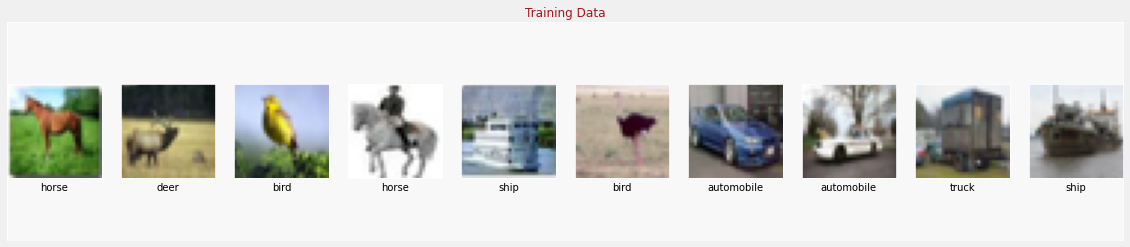

In [5]:
display_images(training_images, training_labels, training_labels, "Training Data" )

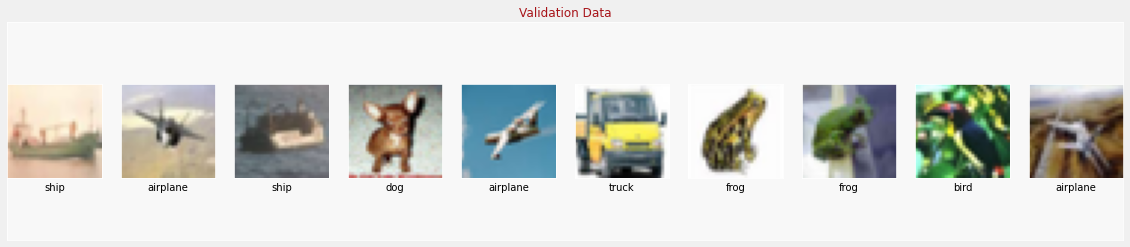

In [6]:
display_images(validation_images, validation_labels, validation_labels, "Training Data" )

In [12]:
def preprocess_image_input(input_images):
  input_images = tf.cast(input_images, tf.float32)
  output = tf.keras.applications.resnet50.preprocess_input(input_images)
  return output

In [13]:
train_X = preprocess_image_input(training_images)
valid_X = preprocess_image_input(validation_images)

In [16]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Flatten, Dense, Input, UpSampling2D

def base_model(inputs):
  base = tf.keras.applications.resnet50.ResNet50(input_shape=(224, 224, 3),
                                                 weights="imagenet",
                                                 include_top=False)
  return base(inputs)

def classifier(inputs):
  x = GlobalAveragePooling2D()(inputs)
  x = Flatten()(x)
  x = Dense(1024, activation='relu')(x)
  x = Dense(512, activation='relu')(x)
  x = Dense(10, activation='softmax', name='classification')(x)
  return x

def final_model(inputs):
  resize = UpSampling2D(size=(7,7))(inputs)
  resnet_base = base_model(resize)
  clf_output = classifier(resnet_base)
  return clf_output

def define_compile_model():
  inputs = Input(shape=(32, 32, 3))
  classification_output = final_model(inputs)

  model = tf.keras.models.Model(inputs=inputs, outputs=classification_output)

  model.compile(loss="sparse_categorical_crossentropy",
                optimizer="Adam",
                metrics=["accuracy"])
  return model

model = define_compile_model()
model.summary()

94781440/94765736 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                              

In [ ]:
EPOCHS = 4
history = model.fit(train_X, training_labels, epochs=EPOCHS, validation_data = (valid_X, validation_labels), batch_size=BATCH_SIZE)

Epoch 1/4


In [ ]:
loss, accuracy = model.evaluate(valid_X, validation_labels, batch_size=64)

In [ ]:
plot_metrics("loss", "Loss")

In [ ]:
plot_metrics("accuracy", "Accuracy")

In [ ]:
probabilities = model.predict(valid_X, batch_size=64)
probabilities = np.argmax(probabilities, axis = 1)

display_images(validation_images, probabilities, validation_labels, "Bad predictions indicated in red.")